<a href="https://colab.research.google.com/github/JTHOMP801/JTHOMP801.github.io/blob/main/CS436_FishRecognizer_JoeThompsonWillThompson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow keras matplotlib numpy



In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import os
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np


In [3]:
drive.mount('/content/drive/')

Mounted at /content/drive/


# **Define Parameters**

**MobileNetV2**

In [5]:
imageSize = (224, 224)
batchSize = 32 #How many images model sees before learning 10 batches = 1 epoch
numClasses = 4  # betta, guppy, gourami, killifish
epochs = 15 #Iterations

# path to data set MAKE SURE THIS IS THE SAME DATAPATH TO YOURS JOE!!!!!!!!
base_dir = '/content/drive/MyDrive/fish_dataset_copy/final_split'

In [6]:
#Randommize training images
# Training data generator, randomizes data to make noise helps generalization
train_datagen = ImageDataGenerator(
    rescale=1./255,  # normalize pixel values to [0,1]
    rotation_range=15,  # randomly rotate images
    zoom_range=0.1,     # random zoom
    width_shift_range=0.1,  # random horizontal shift
    height_shift_range=0.1, # random vertical shift
    horizontal_flip=True  # randomly flip images horizontally
)

# Validation and test data generator
val_test_datagen = ImageDataGenerator(rescale=1./255) #changes the data in batches to get rid of overfitting

# Load the images from folders
train_generator = train_datagen.flow_from_directory( #applies augmentation from train_datagen to data
    directory=os.path.join(base_dir, 'train'), #this file path
    target_size=imageSize,  # resize
    batch_size=batchSize,   # specifices batch size
    class_mode='categorical' #one hot encoded
)

val_generator = val_test_datagen.flow_from_directory( # same as above but on validation set
    directory=os.path.join(base_dir, 'val'),
    target_size=imageSize,
    batch_size=batchSize,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory( # same as above but test set
    directory=os.path.join(base_dir, 'test'),
    target_size=imageSize,
    batch_size=batchSize,
    class_mode='categorical',
    shuffle=False  # important for evaluation later
)

Found 195 images belonging to 4 classes.
Found 40 images belonging to 4 classes.
Found 47 images belonging to 4 classes.


In [7]:
#  Build the MobileNetV2 model (transfer learning)

from tensorflow.keras.applications import MobileNetV2

# Load the MobileNetV2 base model
base_model = MobileNetV2(
    weights='imagenet',  # use pretrained weights from ImageNet
    include_top=False,   # don't include the default classifier layer
    input_shape=(224, 224, 3)  # input size must match our images
)

# Freeze the base model layers (so they don't change during initial training)
base_model.trainable = False

# Add a custom head
from tensorflow.keras import layers, models

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(numClasses, activation='softmax')  # output layer: 4 classes, softmax
])

# Show model summary (optional but very helpful!)
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
#  Compile the model (define loss function, optimizer, and metrics)

model.compile(
    optimizer=Adam(learning_rate=0.0001),  # small learning rate for transfer learning
    loss='categorical_crossentropy',       # because it's multi-class classification
    metrics=['accuracy']                   # we want to monitor accuracy
)

In [9]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 102s 14s/step - accuracy: 0.2496 - loss: 1.5942 - val_accuracy: 0.5000 - val_loss: 1.2634
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.4435 - loss: 1.2254 - val_accuracy: 0.6250 - val_loss: 1.1138
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.5798 - loss: 1.0689 - val_accuracy: 0.6750 - val_loss: 1.0119
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.6932 - loss: 0.9080 - val_accuracy: 0.7000 - val_loss: 0.9044
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.7448 - loss: 0.8142 - val_accuracy: 0.7000 - val_loss: 0.8248
Epoch 6/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.7911 - loss: 0.7693 - val_accuracy: 0.7750 - val_loss: 0.7579
Epoch 7/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.7696 - loss: 0.6891 - val_accuracy: 0.7500 - val_loss: 0.7154
Epoch 8/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.8400 - loss: 0.6021 - val_accuracy: 0.7750 - val_loss: 0.6811
Epoch 

In [10]:

test_loss, test_accuracy = model.evaluate(test_generator)
print(f" Test accuracy: {test_accuracy:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 550ms/step - accuracy: 0.8165 - loss: 0.5089
 Test accuracy: 0.79


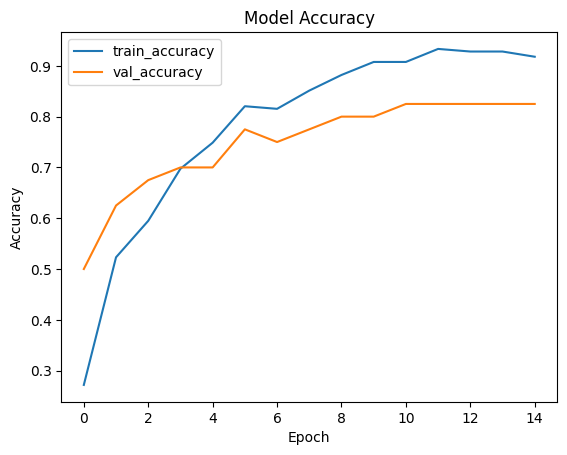

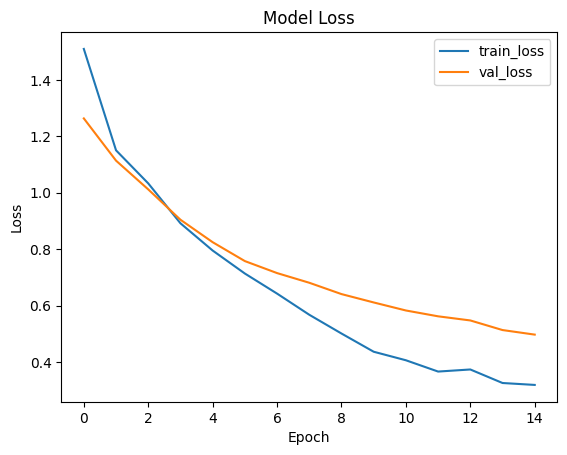

In [11]:
#  Plot Training Curves

import matplotlib.pyplot as plt

# Accuracy curve
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Loss curve
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step


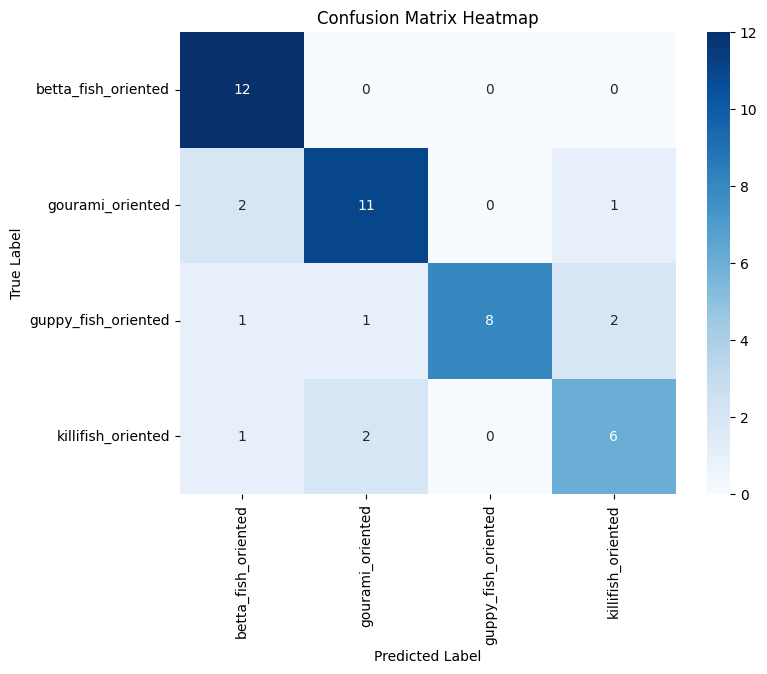


Classification Report:

                     precision    recall  f1-score   support

betta_fish_oriented       0.75      1.00      0.86        12
   gourami_oriented       0.79      0.79      0.79        14
guppy_fish_oriented       1.00      0.67      0.80        12
 killifish_oriented       0.67      0.67      0.67         9

           accuracy                           0.79        47
          macro avg       0.80      0.78      0.78        47
       weighted avg       0.81      0.79      0.78        47



In [12]:

#Predict labels for the test set
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes) #confusion matrix

#heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print("\nClassification Report:\n")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 523ms/step


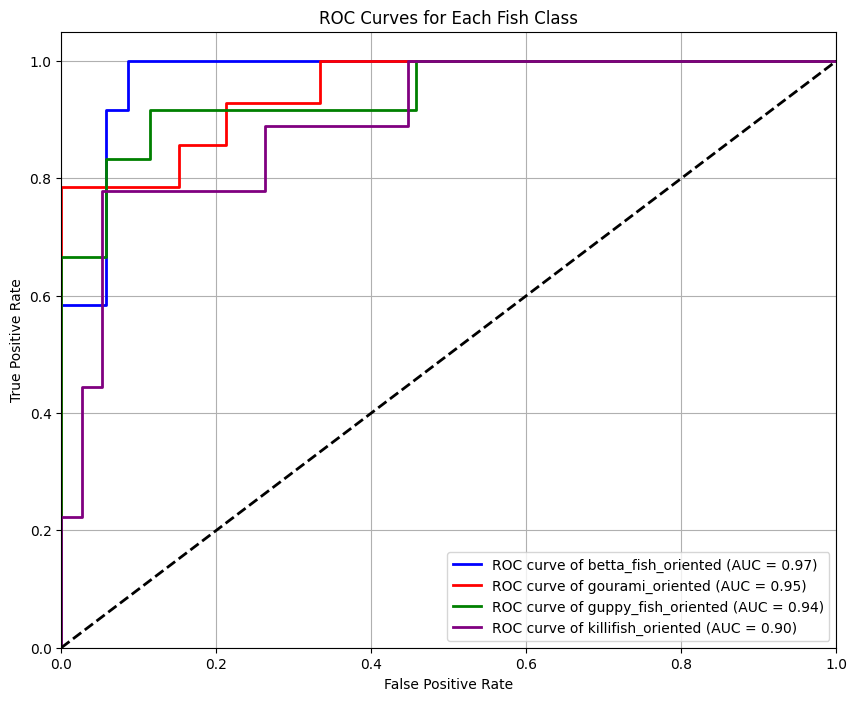

 AUC Scores per Class:
betta_fish_oriented: AUC = 0.97
gourami_oriented: AUC = 0.95
guppy_fish_oriented: AUC = 0.94
killifish_oriented: AUC = 0.90


In [13]:
#ROC AUC
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

y_probs = model.predict(test_generator)  # shape: (num_samples, num_classes)

#true labels (binarize for multiclass ROC)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

#binarize true labels (needed for multiclass ROC)
y_true_binarized = label_binarize(y_true, classes=range(len(class_names)))

# compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#plot
plt.figure(figsize=(10, 8))

colors = ['blue', 'red', 'green', 'purple']
for i, color in zip(range(len(class_names)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {class_names[i]} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # random chance line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Fish Class')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# print
print(" AUC Scores per Class:")
for i in range(len(class_names)):
    print(f"{class_names[i]}: AUC = {roc_auc[i]:.2f}")


In [15]:
# Save the trained model
#HITTING PLAY WILL OVERRIDE CURRENT SAVED MODEL

save_path = '/content/drive/MyDrive/fish_dataset_copy/mobilenetv2_fish_classifier.h5'
model.save(save_path)

print(f" Model saved to: {save_path}")

 Model saved to: /content/drive/MyDrive/fish_dataset_copy/mobilenetv2_fish_classifier.h5


## **EfficientNetB8**

In [16]:
from tensorflow.keras.applications.efficientnet import preprocess_input
#preprocessing specific to EfficientNetB8

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,   #Use model-specific preprocessing
    rotation_range=20,           #more rotation: better robustness
    zoom_range=0.2,            #stronger zoom
    width_shift_range=0.2,         #stronger horizontal shift
    height_shift_range=0.2,         #stronger vertical shift
    brightness_range=[0.7, 1.3],          #vary brightness more
    shear_range=10,            #random shearing (simulates fish skew)
    horizontal_flip=True,            #flip images horizontally
    fill_mode='nearest',            #fill missing pixels properly
    validation_split=0.2            #Split for validation if needed
)

# Validation and test data generator (only preprocess, no augmentation)
val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Load the images from folders
train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'train'),
    target_size=imageSize,
    batch_size=batchSize,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'val'),
    target_size=imageSize,
    batch_size=batchSize,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'test'),
    target_size=imageSize,
    batch_size=batchSize,
    class_mode='categorical',
    shuffle=False  # important for evaluation later
)

Found 195 images belonging to 4 classes.
Found 40 images belonging to 4 classes.
Found 47 images belonging to 4 classes.


In [17]:
#EfficientNetB0
from tensorflow.keras.applications import EfficientNetB0

#Load the base model (No custom hyperparameters)
base_model = EfficientNetB0(
    weights='imagenet',     # Pretrained on ImageNet
    include_top=False,      # Remove top classifier
    input_shape=(224, 224, 3)
)

#freeze base layers
base_model.trainable = False

#add custom classification head
from tensorflow.keras import layers, models

model = models.Sequential([   #head of original model is replaced with this
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(numClasses, activation='softmax')
])


model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,055 (16.08 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [18]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#  Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.2525 - loss: 1.4899 - val_accuracy: 0.2500 - val_loss: 1.3765
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.3808 - loss: 1.3005 - val_accuracy: 0.5000 - val_loss: 1.2266
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.5588 - loss: 1.1777 - val_accuracy: 0.5750 - val_loss: 1.1082
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.6704 - loss: 1.0187 - val_accuracy: 0.6750 - val_loss: 1.0028
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.7291 - loss: 0.9525 - val_accuracy: 0.8250 - val_loss: 0.9145
Epoch 6/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.7464 - loss: 0.8997 - val_accuracy: 0.8250 - val_loss: 0.8404
Epoch 7/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.8158 - loss: 0.7982 - val_accuracy: 0.8250 - val_loss: 0.7730
Epoch 8/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.8121 - loss: 0.7730 - val_accuracy: 0.8750 - val_loss: 0.7159
Epoch 9/

In [19]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f" EfficientNetB0 Test Accuracy: {test_accuracy:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.8941 - loss: 0.4509
 EfficientNetB0 Test Accuracy: 0.87


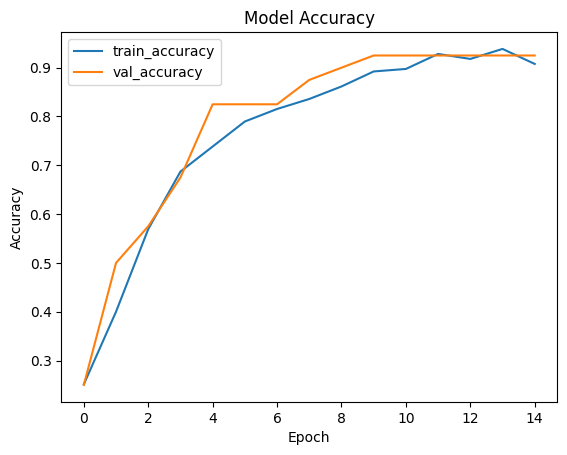

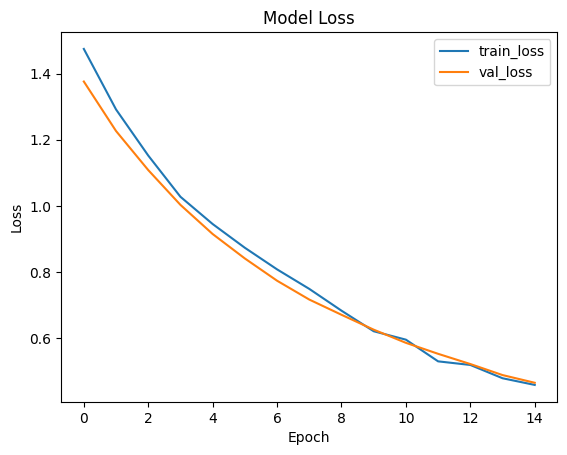

In [21]:
#Accuracy curve
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

#Loss curve
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Main Point: EfficientNetB0 is too heavy for a small, clean dataset like yours unless tuned super carefully. EfficientNetB0 performs better with 100k+ images it is not meant for a small dataset like this

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step


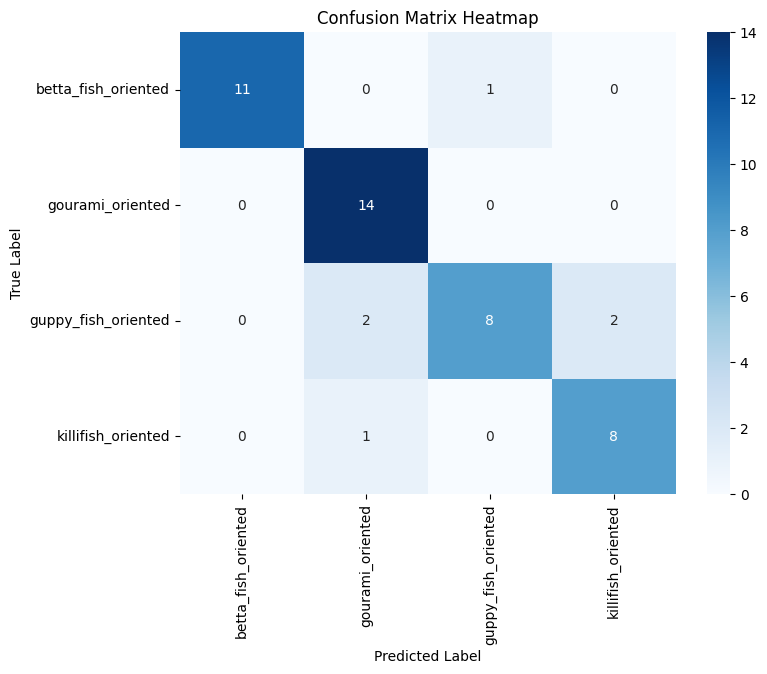


Classification Report:

                     precision    recall  f1-score   support

betta_fish_oriented       1.00      0.92      0.96        12
   gourami_oriented       0.82      1.00      0.90        14
guppy_fish_oriented       0.89      0.67      0.76        12
 killifish_oriented       0.80      0.89      0.84         9

           accuracy                           0.87        47
          macro avg       0.88      0.87      0.87        47
       weighted avg       0.88      0.87      0.87        47



In [22]:
#confusion matrix heatmap

predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

#confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

#plot
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print("\nClassification Report:\n")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 890ms/step


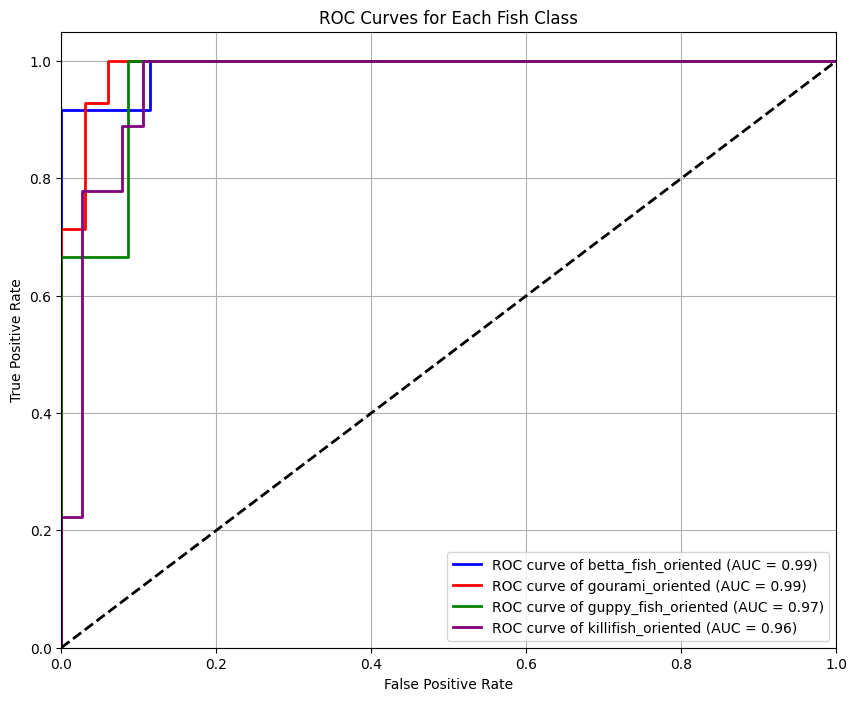

 AUC Scores per Class:
betta_fish_oriented: AUC = 0.99
gourami_oriented: AUC = 0.99
guppy_fish_oriented: AUC = 0.97
killifish_oriented: AUC = 0.96


In [23]:
#predict probabilities
y_probs = model.predict(test_generator)  # shape: (num_samples, num_classes)

#true labels (binarize for multiclass ROC)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

#binarize true labels (needed for multiclass ROC)
y_true_binarized = label_binarize(y_true, classes=range(len(class_names)))

#compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#plot
plt.figure(figsize=(10, 8))

colors = ['blue', 'red', 'green', 'purple']  # one color per class
for i, color in zip(range(len(class_names)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {class_names[i]} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # random chance line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Fish Class')
plt.legend(loc="lower right")
plt.grid()
plt.show()

print(" AUC Scores per Class:")
for i in range(len(class_names)):
    print(f"{class_names[i]}: AUC = {roc_auc[i]:.2f}")

In [24]:
#save the trained model
#HITTING PLAY WILL OVERRIDE CURRENT SAVED MODEL
save_path = '/content/drive/MyDrive/fish_dataset_copy/EfficientNetB0_fish_classifier.h5'
model.save(save_path)

print(f" Model saved to: {save_path}")

 Model saved to: /content/drive/MyDrive/fish_dataset_copy/EfficientNetB0_fish_classifier.h5


## **ResNet50**

In [25]:
from tensorflow.keras.applications.resnet50 import preprocess_input

# Training data generator with better augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  #preprocessing for ResNet50
    rotation_range=20,        # slightly more rotation
    zoom_range=0.15,          # slightly more zoom
    width_shift_range=0.2,    # allow more horizontal movement
    height_shift_range=0.2,   # allow more vertical movement
    brightness_range=[0.8, 1.2], # <<< NEW: slight random brightness change
    horizontal_flip=True,     # still flip horizontally
    fill_mode='nearest',      # fill in any missing pixels after shift/rotate
    validation_split=0.2      # 20% validation split
)

#validation and test data generator (no augmentation, only preprocessing)
val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

#load the images from folders
train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'train'),
    target_size=imageSize,
    batch_size=batchSize,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'val'),
    target_size=imageSize,
    batch_size=batchSize,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'test'),
    target_size=imageSize,
    batch_size=batchSize,
    class_mode='categorical',
    shuffle=False  # important for evaluation
)


Found 195 images belonging to 4 classes.
Found 40 images belonging to 4 classes.
Found 47 images belonging to 4 classes.


In [26]:
#  Build ResNet50 model

from tensorflow.keras.applications import ResNet50

base_model = ResNet50(
    weights='imagenet',         #use pretrained ImageNet weights
    include_top=False,          #remove old classification head
    input_shape=(224, 224, 3)    # same as our size
)

base_model.trainable = False  #freeze the base model initially

from tensorflow.keras import layers, models

#build the full model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(numClasses, activation='softmax')
])

# Show model summary
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,500 (90.98 MB)

 Trainable params: 262,788 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [28]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),  #low learning rate for fine-tuning
    loss='categorical_crossentropy',       #multi-class classification loss
    metrics=['accuracy']                   #track accuracy during training
)


In [30]:
#  Train the ResNet50 model

history_resnet50 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)

Epoch 1/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 56s 7s/step - accuracy: 0.1606 - loss: 2.3349 - val_accuracy: 0.4250 - val_loss: 1.3330
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 82s 7s/step - accuracy: 0.4441 - loss: 1.3150 - val_accuracy: 0.5500 - val_loss: 1.1940
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 47s 8s/step - accuracy: 0.5676 - loss: 1.1192 - val_accuracy: 0.5750 - val_loss: 1.0062
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 47s 7s/step - accuracy: 0.6697 - loss: 0.9663 - val_accuracy: 0.7250 - val_loss: 0.8127
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 84s 7s/step - accuracy: 0.7508 - loss: 0.7778 - val_accuracy: 0.7500 - val_loss: 0.7162
Epoch 6/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 48s 7s/step - accuracy: 0.8101 - loss: 0.6512 - val_accuracy: 0.8250 - val_loss: 0.6368
Epoch 7/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 47s 8s/step - accuracy: 0.8180 - loss: 0.6552 - val_accuracy: 0.8250 - val_loss: 0.5669
Epoch 8/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 51s 7s/step - accuracy: 0.8718 - loss: 0.5381 - val_accuracy: 0.8500 - val_loss: 0.5122
Epoch 9/

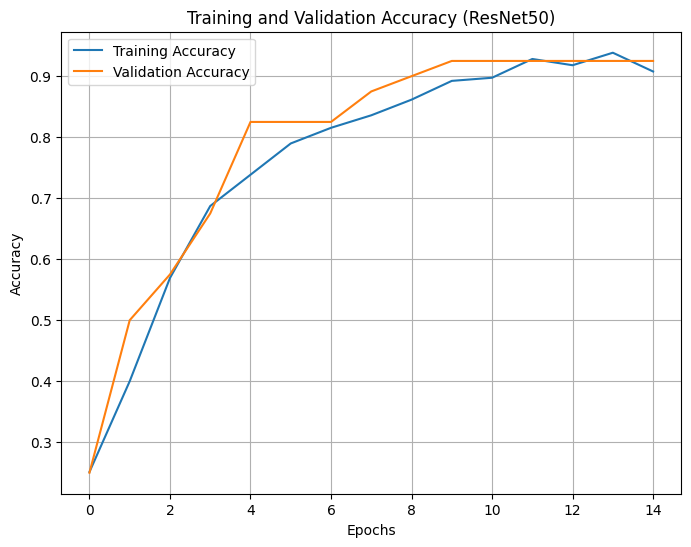

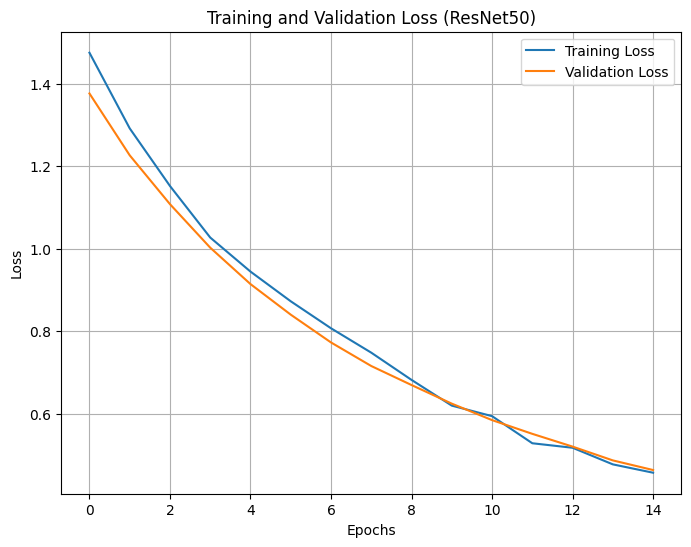

In [31]:
#Accuracy and Loss ResNet50
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (ResNet50)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (ResNet50)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f" EfficientNetB0 Test Accuracy: {test_accuracy:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.8449 - loss: 0.4167
 EfficientNetB0 Test Accuracy: 0.83


1/2 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step


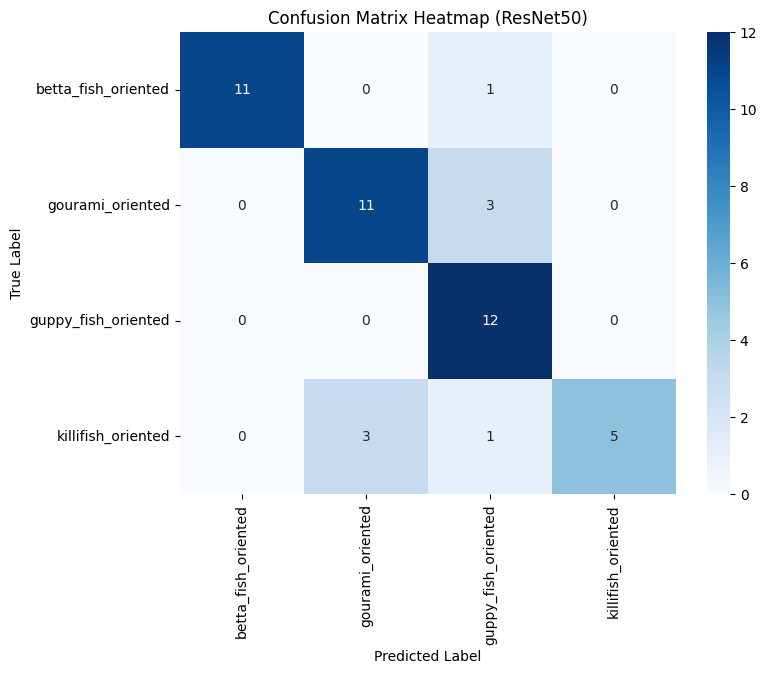


Classification Report (ResNet50):

                     precision    recall  f1-score   support

betta_fish_oriented       1.00      0.92      0.96        12
   gourami_oriented       0.79      0.79      0.79        14
guppy_fish_oriented       0.71      1.00      0.83        12
 killifish_oriented       1.00      0.56      0.71         9

           accuracy                           0.83        47
          macro avg       0.87      0.81      0.82        47
       weighted avg       0.86      0.83      0.83        47



In [33]:
#predict labels for the test set
predictions_resnet50 = model.predict(test_generator)
predicted_classes_resnet50 = np.argmax(predictions_resnet50, axis=1)
true_classes_resnet50 = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

#create confusion matrix
cm_resnet50 = confusion_matrix(true_classes_resnet50, predicted_classes_resnet50)

#plot
plt.figure(figsize=(8,6))
sns.heatmap(cm_resnet50, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix Heatmap (ResNet50)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print("\nClassification Report (ResNet50):\n")
print(classification_report(true_classes_resnet50, predicted_classes_resnet50, target_names=class_labels))

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


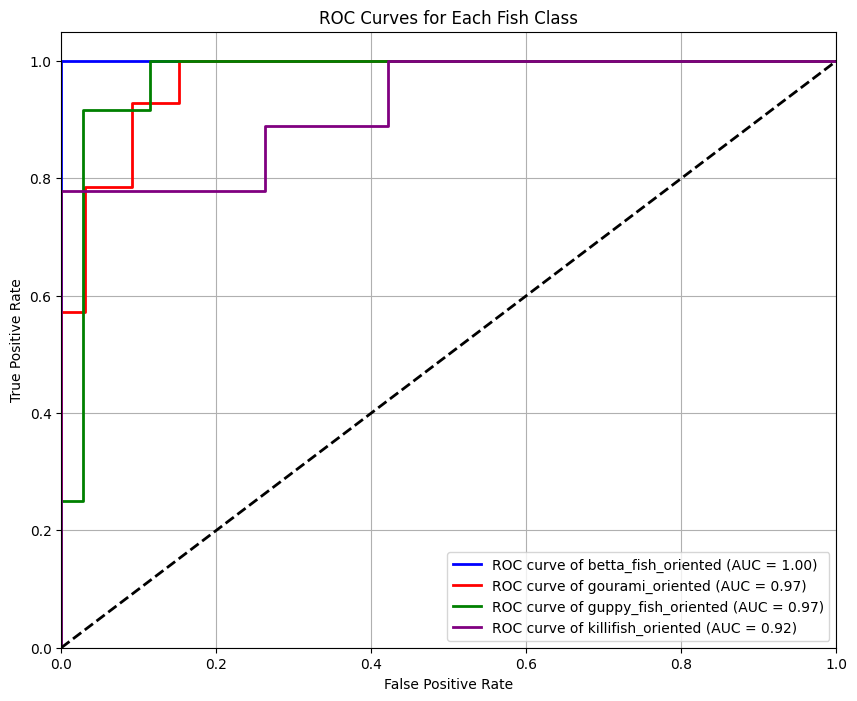

 AUC Scores per Class:
betta_fish_oriented: AUC = 1.00
gourami_oriented: AUC = 0.97
guppy_fish_oriented: AUC = 0.97
killifish_oriented: AUC = 0.92


In [34]:
#predict probabilities
y_probs = model.predict(test_generator)  # shape: (num_samples, num_classes)

#true labels (binarize for multiclass ROC)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

#binarize true labels (needed for multiclass ROC)
y_true_binarized = label_binarize(y_true, classes=range(len(class_names)))

#compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#plot all ROC curves
plt.figure(figsize=(10, 8))

colors = ['blue', 'red', 'green', 'purple']  # one color per class
for i, color in zip(range(len(class_names)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {class_names[i]} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # random chance line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Fish Class')
plt.legend(loc="lower right")
plt.grid()
plt.show()

#print
print(" AUC Scores per Class:")
for i in range(len(class_names)):
    print(f"{class_names[i]}: AUC = {roc_auc[i]:.2f}")

In [35]:
# Save the trained model
#HITTING PLAY WILL OVERRIDE CURRENT SAVED MODEL
save_path = '/content/drive/MyDrive/fish_dataset_copy/ResNet50_fish_classifier.h5'
model.save(save_path)

print(f" Model saved to: {save_path}")

 Model saved to: /content/drive/MyDrive/fish_dataset_copy/ResNet50_fish_classifier.h5


In [37]:
from tensorflow.keras.applications import MobileNetV3Small

# Load the MobileNetV3 base model
base_model = MobileNetV3Small(
    weights='imagenet',  #use pretrained weights from ImageNet
    include_top=False,   #don't include the default classifier layer
    input_shape=(224, 224, 3)
)

#freeze the base model layers (so they don't change during initial training)
base_model.trainable = False

#Add a custom head
from tensorflow.keras import layers, models

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(numClasses, activation='softmax')  # output layer: 4 classes, softmax
])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,013,492 (3.87 MB)

 Trainable params: 74,372 (290.52 KB)

 Non-trainable params: 939,120 (3.58 MB)

In [38]:
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

#training data generator
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

#validation and test data generator
val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

#load data
train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'train'),
    target_size=imageSize,
    batch_size=batchSize,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'val'),
    target_size=imageSize,
    batch_size=batchSize,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'test'),
    target_size=imageSize,
    batch_size=batchSize,
    class_mode='categorical',
    shuffle=False
)

Found 195 images belonging to 4 classes.
Found 40 images belonging to 4 classes.
Found 47 images belonging to 4 classes.


In [39]:
#compile
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train MobileNetV3 model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.3089 - loss: 1.3888 - val_accuracy: 0.3250 - val_loss: 1.3129
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 988ms/step - accuracy: 0.4160 - loss: 1.2236 - val_accuracy: 0.4500 - val_loss: 1.2065
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 998ms/step - accuracy: 0.5123 - loss: 1.1399 - val_accuracy: 0.6000 - val_loss: 1.1136
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6355 - loss: 1.0039 - val_accuracy: 0.6000 - val_loss: 1.0492
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 822ms/step - accuracy: 0.6365 - loss: 0.9475 - val_accuracy: 0.6500 - val_loss: 0.9957
Epoch 6/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6967 - loss: 0.8926 - val_accuracy: 0.7250 - val_loss: 0.9198
Epoch 7/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 824ms/step - accuracy: 0.7458 - loss: 0.8012 - val_accuracy: 0.7250 - val_loss: 0.8563
Epoch 8/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7885 - loss: 0.7878 - val_accuracy: 0.7500 - val_loss: 0.8248
Ep

In [40]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f" EfficientNetB0 Test Accuracy: {test_accuracy:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - accuracy: 0.7673 - loss: 0.6218
 EfficientNetB0 Test Accuracy: 0.74


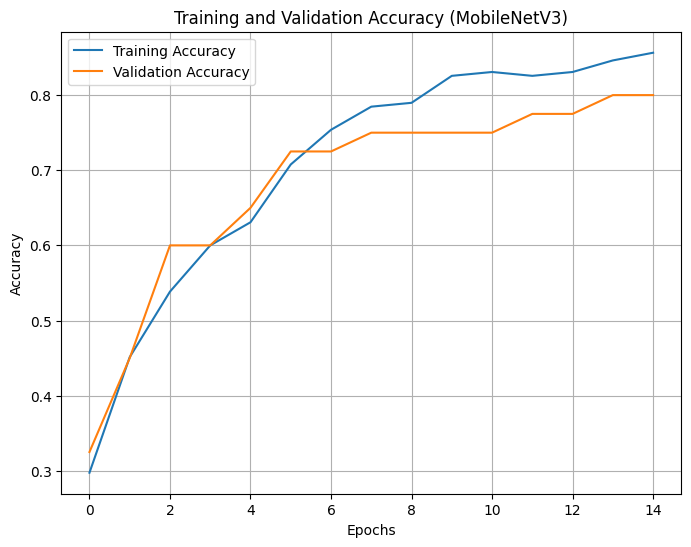

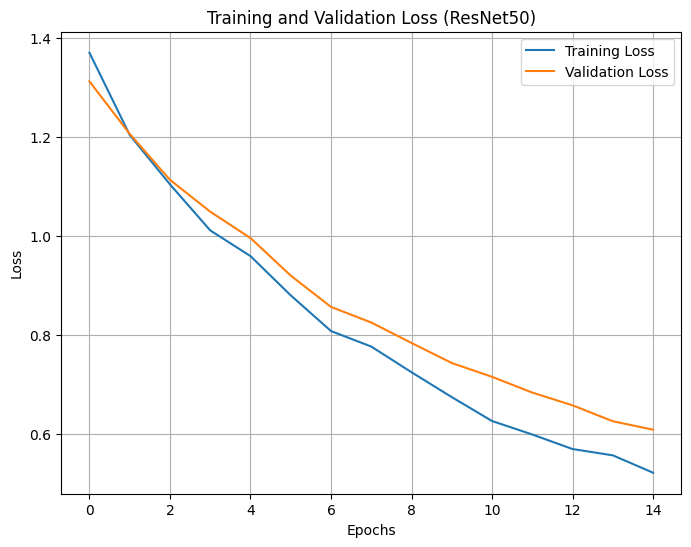

In [41]:
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (MobileNetV3)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (ResNet50)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step


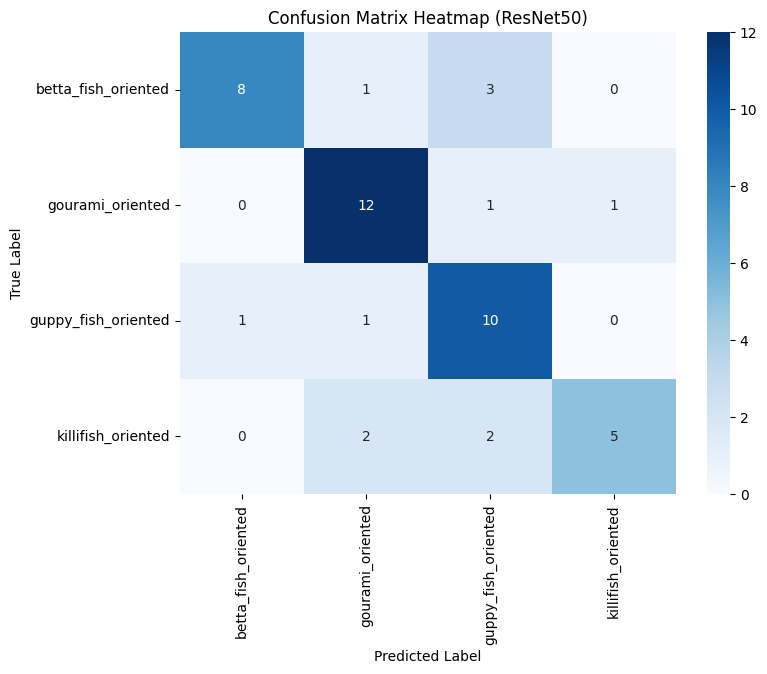


Classification Report (ResNet50):

                     precision    recall  f1-score   support

betta_fish_oriented       0.89      0.67      0.76        12
   gourami_oriented       0.75      0.86      0.80        14
guppy_fish_oriented       0.62      0.83      0.71        12
 killifish_oriented       0.83      0.56      0.67         9

           accuracy                           0.74        47
          macro avg       0.77      0.73      0.74        47
       weighted avg       0.77      0.74      0.74        47



In [42]:
#predict labels for the test set
predictions_resnet50 = model.predict(test_generator)
predicted_classes_resnet50 = np.argmax(predictions_resnet50, axis=1)
true_classes_resnet50 = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

#create confusion matrix
cm_resnet50 = confusion_matrix(true_classes_resnet50, predicted_classes_resnet50)

#plot the heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm_resnet50, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix Heatmap (ResNet50)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


print("\nClassification Report (ResNet50):\n")
print(classification_report(true_classes_resnet50, predicted_classes_resnet50, target_names=class_labels))

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 355ms/step


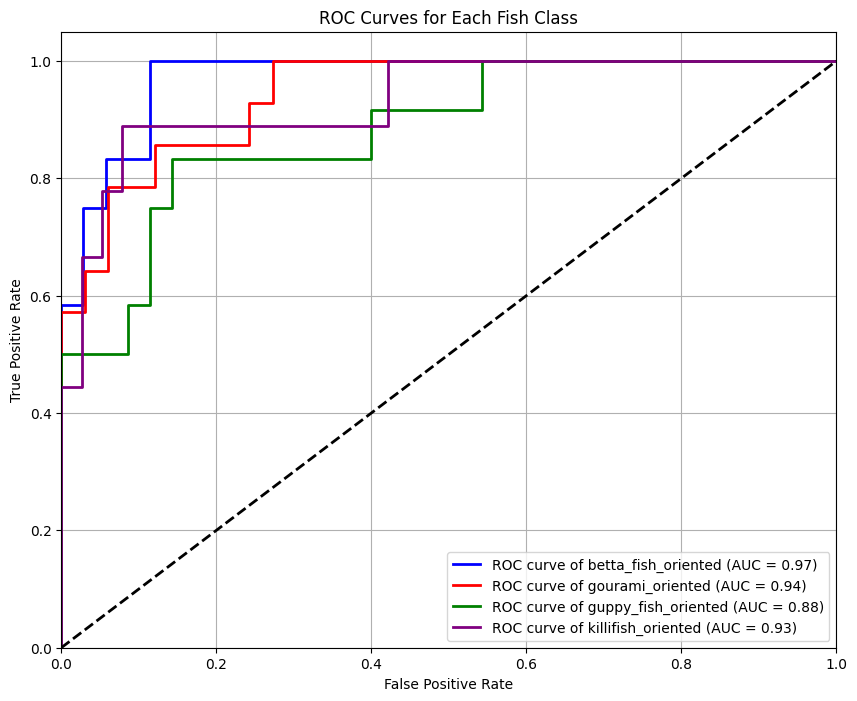

 AUC Scores per Class:
betta_fish_oriented: AUC = 0.97
gourami_oriented: AUC = 0.94
guppy_fish_oriented: AUC = 0.88
killifish_oriented: AUC = 0.93


In [43]:
#predict probabilities (not labels)
y_probs = model.predict(test_generator)  # shape: (num_samples, num_classes)

#true labels (binarize for multiclass ROC)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

#binarize true labels
y_true_binarized = label_binarize(y_true, classes=range(len(class_names)))

#compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#plot all ROC curves
plt.figure(figsize=(10, 8))

colors = ['blue', 'red', 'green', 'purple']
for i, color in zip(range(len(class_names)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {class_names[i]} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # random chance line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Fish Class')
plt.legend(loc="lower right")
plt.grid()
plt.show()

print(" AUC Scores per Class:")
for i in range(len(class_names)):
    print(f"{class_names[i]}: AUC = {roc_auc[i]:.2f}")

In [44]:
# Save the trained model
#HITTING PLAY WILL OVERRIDE CURRENT SAVED MODEL
save_path = '/content/drive/MyDrive/fish_dataset_copy/MobileNetV3Small_fish_classifier.h5'
model.save(save_path)

print(f" Model saved to: {save_path}")

 Model saved to: /content/drive/MyDrive/fish_dataset_copy/MobileNetV3Small_fish_classifier.h5


## **Final Model Selection**

In [45]:
#Look at copy for this, right version of tensorflow is successfully downloaded on this
#the problem is how the version of tensorflow save the models. version 2.13.0 fixes this


#from tensorflow.keras.models import load_model

#EfficientNetB0_model = load_model('/content/drive/MyDrive/fish_dataset_copy/EfficientNetB0_fish_classifier.h5')
#MobileNetV2_model = load_model('/content/drive/MyDrive/fish_dataset_copy/mobilenetv2_fish_classifier.h5')
#MobileNetV3Small_model = load_model('/content/drive/MyDrive/fish_dataset_copy/MobileNetV3Small_fish_classifier.h5')
#ResNet50_model = load_model('/content/drive/MyDrive/fish_dataset_copy/ResNet50_fish_classifier.h5')

# **Best Performing Model EfficientNetB0**

In [48]:
!pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.8 MB/s eta 0:00:00


In [49]:
import keras_tuner as kt
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, optimizers

In [50]:
def build_model(hp):
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False

    model = models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())


    model.add(layers.Dense(
        hp.Choice('dense_units', [64, 128, 256]),
        activation='relu'
    ))


    model.add(layers.Dropout(
        hp.Float('dropout_rate', 0.2, 0.5, step=0.1)
    ))


    model.add(layers.Dense(4, activation='softmax'))  # 4 fish classes

    model.compile(
        optimizer=optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', [1e-4, 1e-3, 1e-2])
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [ ]:
#intialize params
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_results',
    project_name='efficientnetb0_tuning'
)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
#actual search
tuner.search(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    verbose=1
)


Trial 10 Complete [00h 04m 45s]
val_accuracy: 0.925000011920929

Best val_accuracy So Far: 0.9750000238418579
Total elapsed time: 00h 47m 53s


In [ ]:
# get best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Best hyperparameters:
- Dense units: {best_hps.get('dense_units')}
- Dropout rate: {best_hps.get('dropout_rate')}
- Learning rate: {best_hps.get('learning_rate')}
""")



Best hyperparameters:
- Dense units: 64
- Dropout rate: 0.4
- Learning rate: 0.001



In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, optimizers

# rebuild model
model = models.Sequential([
    EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3)
    ),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),     # best dense units = 64
    layers.Dropout(0.4),                      # best dropout = 0.4
    layers.Dense(4, activation='softmax')     # 4 classes: betta, gourami, guppy, killifish
])

#compile model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),   # best learning rate = 0.001
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,   #epochs 10 because model overfit past this, validation droped to 60
    verbose=1
)




Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 142s 10s/step - accuracy: 0.3982 - loss: 1.2863 - val_accuracy: 0.9250 - val_loss: 0.3474
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 66s 9s/step - accuracy: 0.9331 - loss: 0.3502 - val_accuracy: 0.9750 - val_loss: 0.0785
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 80s 9s/step - accuracy: 0.9458 - loss: 0.1748 - val_accuracy: 0.9000 - val_loss: 0.3178
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 67s 11s/step - accuracy: 0.8590 - loss: 0.4196 - val_accuracy: 0.8750 - val_loss: 0.8458
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 63s 9s/step - accuracy: 0.9427 - loss: 0.1944 - val_accuracy: 0.8500 - val_loss: 1.4621
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 64s 9s/step - accuracy: 0.9780 - loss: 0.0912 - val_accuracy: 0.8750 - val_loss: 1.3181
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 65s 11s/step - accuracy: 0.9086 - loss: 0.2681 - val_accuracy: 0.9250 - val_loss: 0.4272
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 64s 9s/step - accuracy: 0.9023 - loss: 0.3120 - val_accuracy: 0.9500 - val_loss: 0.1143
Epoc

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f" EfficientNetB0 Test Accuracy: {test_accuracy:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 822ms/step - accuracy: 0.8449 - loss: 0.4321
 EfficientNetB0 Test Accuracy: 0.83


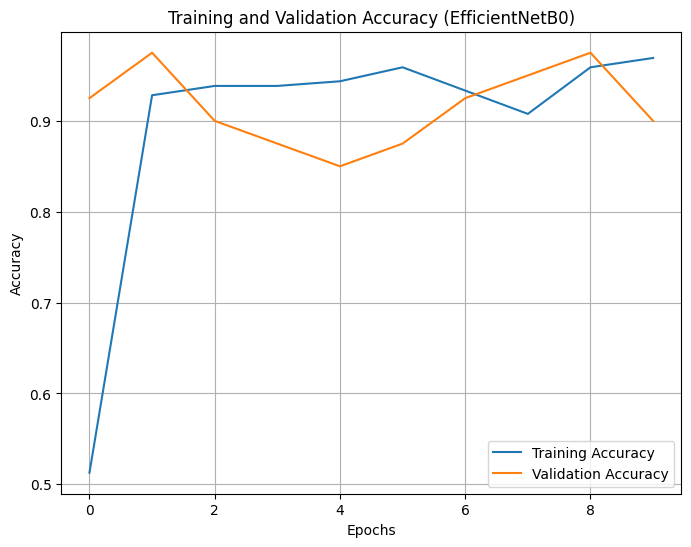

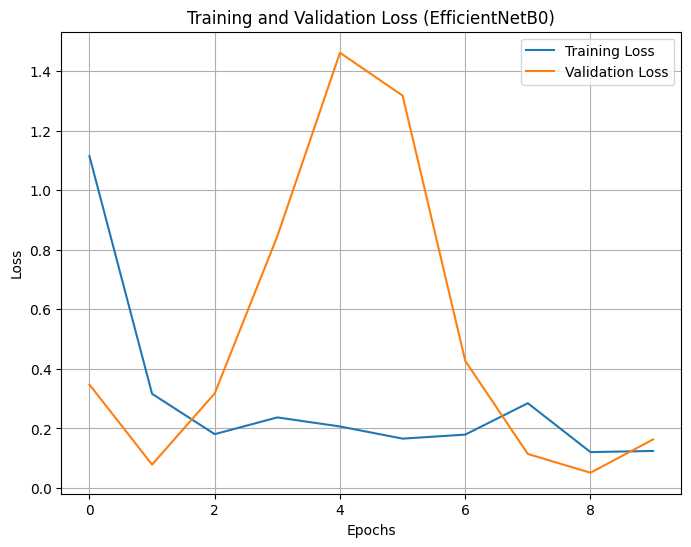

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (EfficientNetB0)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (EfficientNetB0)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step


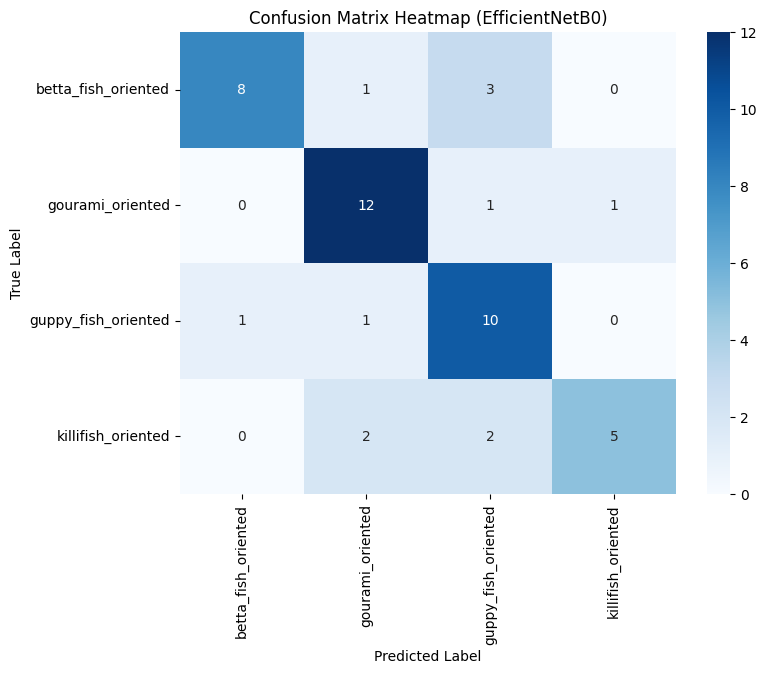


Classification Report (Best)

                     precision    recall  f1-score   support

betta_fish_oriented       0.89      0.67      0.76        12
   gourami_oriented       0.75      0.86      0.80        14
guppy_fish_oriented       0.62      0.83      0.71        12
 killifish_oriented       0.83      0.56      0.67         9

           accuracy                           0.74        47
          macro avg       0.77      0.73      0.74        47
       weighted avg       0.77      0.74      0.74        47



In [51]:
#predict labels for the test set
predictions_Best = model.predict(test_generator)
predicted_classes_Best = np.argmax(predictions_Best, axis=1)
true_classes_Best = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

#create confusion matrix
cm_Best = confusion_matrix(true_classes_Best, predicted_classes_Best)

#plot the heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm_Best, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix Heatmap (EfficientNetB0)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print("\nClassification Report (Best)\n")
print(classification_report(true_classes_Best, predicted_classes_Best, target_names=class_labels))

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 790ms/step


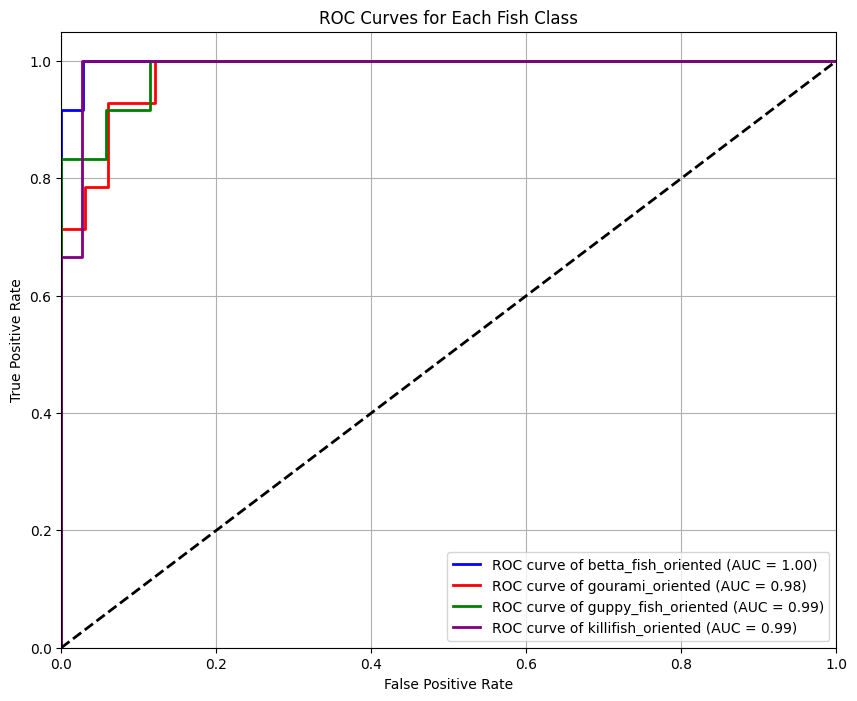

 AUC Scores per Class:
betta_fish_oriented: AUC = 1.00
gourami_oriented: AUC = 0.98
guppy_fish_oriented: AUC = 0.99
killifish_oriented: AUC = 0.99


In [ ]:
#predict probabilities (not labels)
y_probs = model.predict(test_generator)  # shape: (num_samples, num_classes)

#true labels (binarize for multiclass ROC)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

#binarize true labels (needed for multiclass ROC)
y_true_binarized = label_binarize(y_true, classes=range(len(class_names)))

#compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#plot all ROC curves
plt.figure(figsize=(10, 8))

colors = ['blue', 'red', 'green', 'purple']
for i, color in zip(range(len(class_names)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {class_names[i]} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # random chance line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Fish Class')
plt.legend(loc="lower right")
plt.grid()
plt.show()

print(" AUC Scores per Class:")
for i in range(len(class_names)):
    print(f"{class_names[i]}: AUC = {roc_auc[i]:.2f}")